In [1]:
import os
import time

import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re

from copo import pretty_print

%matplotlib inline

In [2]:
EVALUATE_RESULTS_PATH = "./formal_evaluate_results"

os.listdir(EVALUATE_RESULTS_PATH)

['1011_ccppo_concat_evaluate_results.csv',
 '1003_copo_formal_evaluate_results.csv',
 '1003_ippo_evaluate_results.csv',
 '1012_ccppo_mf_evaluate_results.csv']

In [3]:
eval_df = []

algo_set = set()
env_set = set()

count = 0

for p in os.listdir(EVALUATE_RESULTS_PATH):
    match = re.search("(.*?)_evaluate_results.csv", p)
    
    if match:
        
        count += 1
        
        exp_name = match[1]
        
        full_p = os.path.abspath(os.path.join(EVALUATE_RESULTS_PATH, p))
        
        try:
            tmp = pd.read_csv(full_p)
        except Exception as e:
            print(full_p)
            raise e

        tmp["exp_name"] = exp_name
        tmp["model_index"] = p
        
        eval_df.append(tmp)
        
        print(f"[{count}] Processed the agent: ", exp_name)
    else:
        print(p, " not exists!")
                
eval_df = pd.concat(eval_df)

[1] Processed the agent:  1011_ccppo_concat
[2] Processed the agent:  1003_copo_formal
[3] Processed the agent:  1003_ippo
[4] Processed the agent:  1012_ccppo_mf


## Process the environment names

In [4]:
eval_df["env"].unique()

array(['Parking', 'Round', 'Bottle', 'PGMap', 'Tollgate', 'Inter'],
      dtype=object)

In [5]:
for env_short_name in ["Inter", "Round", "Parking", "Bottle", "Tollgate"]:
    eval_df.loc[
        [env_short_name in item for item in eval_df.env],
        "env"
    ] = env_short_name
    
eval_df.loc[
    ["MetaDrive" in item for item in eval_df.env],
    "env"
] = "PGMap"

In [6]:
eval_df.env.unique()

array(['Parking', 'Round', 'Bottle', 'PGMap', 'Tollgate', 'Inter'],
      dtype=object)

In [7]:
eval_df.keys()

Index(['Unnamed: 0', 'velocity_step_mean_episode_min',
       'velocity_step_mean_episode_mean', 'velocity_step_mean_episode_max',
       'energy_step_mean_episode_min', 'energy_step_mean_episode_mean',
       'energy_step_mean_episode_max', 'num_neighbours_mean_episode_mean',
       'num_neighbours_mean_episode_max', 'num_agents_total',
       'num_agents_total_per_300_steps', 'success_rate', 'num_agents_success',
       'num_agents_success_per_300_steps', 'num_agents_failed_per_300_steps',
       'episode_reward_mean', 'episode_reward_min', 'episode_reward_max',
       'episode_cost_mean', 'episode_cost_min', 'episode_cost_max',
       'episode_cost_sum', 'crash_rate', 'num_agents_crash', 'out_rate',
       'num_agents_out', 'episode_length_mean', 'success_episode_length_mean',
       'svo_estimate_deg_mean', 'svo_estimate_deg_min', 'svo_estimate_deg_max',
       'svo_reward', 'path', 'count', 'algo', 'env', 'seed', 'trial',
       'trial_path', 'should_wrap_copo_env', 'should_wrap_c

## Discarding useless checkpoints according to max success rate rule

In [8]:
eval_df[
    (eval_df.env=="PGMap") &
    (eval_df.exp_name == "1003_ippo")
]

,Unnamed: 0,velocity_step_mean_episode_min,velocity_step_mean_episode_mean,velocity_step_mean_episode_max,energy_step_mean_episode_min,energy_step_mean_episode_mean,energy_step_mean_episode_max,num_neighbours_mean_episode_mean,num_neighbours_mean_episode_max,num_agents_total,...,algo,env,seed,trial,trial_path,should_wrap_copo_env,should_wrap_cc_env,episode,exp_name,model_index
380,380,0.0,43.361539,77.343168,0.0,0.069799,0.150884,1.927375,10.4,72,...,1003_ippo,PGMap,5000,IPPO_MultiAgentMetaDrive_ad347_00005_5_env=Mul...,/home/zhenghao/CoPO/copo_code/copo/1003_ippo/I...,False,False,1,1003_ippo,1003_ippo_evaluate_results.csv
381,381,0.0,40.967634,80.645227,0.0,0.065800,0.161887,2.094833,10.4,76,...,1003_ippo,PGMap,5000,IPPO_MultiAgentMetaDrive_ad347_00005_5_env=Mul...,/home/zhenghao/CoPO/copo_code/copo/1003_ippo/I...,False,False,2,1003_ippo,1003_ippo_evaluate_results.csv
382,382,0.0,41.321030,80.769594,0.0,0.065932,0.162857,2.082051,10.4,76,...,1003_ippo,PGMap,5000,IPPO_MultiAgentMetaDrive_ad347_00005_5_env=Mul...,/home/zhenghao/CoPO/copo_code/copo/1003_ippo/I...,False,False,3,1003_ippo,1003_ippo_evaluate_results.csv
383,383,0.0,45.873053,78.928742,0.0,0.075986,0.155901,1.749560,10.4,75,...,1003_ippo,PGMap,5000,IPPO_MultiAgentMetaDrive_ad347_00005_5_env=Mul...,/home/zhenghao/CoPO/copo_code/copo/1003_ippo/I...,False,False,4,1003_ippo,1003_ippo_evaluate_results.csv
384,384,0.0,44.214634,80.491442,0.0,0.071959,0.162153,1.808043,10.4,71,...,1003_ippo,PGMap,5000,IPPO_MultiAgentMetaDrive_ad347_00005_5_env=Mul...,/home/zhenghao/CoPO/copo_code/copo/1003_ippo/I...,False,False,5,1003_ippo,1003_ippo_evaluate_results.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3555,3555,0.0,10.122895,30.244837,0.0,0.010925,0.036841,3.383230,10.4,61,...,1003_ippo,PGMap,12000,IPPO_MultiAgentMetaDrive_ad347_00047_47_env=Mu...,/home/zhenghao/CoPO/copo_code/copo/1003_ippo/I...,False,False,16,1003_ippo,1003_ippo_evaluate_results.csv
3556,3556,0.0,9.888277,19.549426,0.0,0.010487,0.022414,3.307890,10.4,61,...,1003_ippo,PGMap,12000,IPPO_MultiAgentMetaDrive_ad347_00047_47_env=Mu...,/home/zhenghao/CoPO/copo_code/copo/1003_ippo/I...,False,False,17,1003_ippo,1003_ippo_evaluate_results.csv
3557,3557,0.0,8.951472,18.907273,0.0,0.009340,0.020177,3.488583,10.4,59,...,1003_ippo,PGMap,12000,IPPO_MultiAgentMetaDrive_ad347_00047_47_env=Mu...,/home/zhenghao/CoPO/copo_code/copo/1003_ippo/I...,False,False,18,1003_ippo,1003_ippo_evaluate_results.csv
3558,3558,0.0,9.690543,34.849641,0.0,0.010298,0.044492,3.433002,10.4,62,...,1003_ippo,PGMap,12000,IPPO_MultiAgentMetaDrive_ad347_00047_47_env=Mu...,/home/zhenghao/CoPO/copo_code/copo/1003_ippo/I...,False,False,19,1003_ippo,1003_ippo_evaluate_results.csv


In [9]:
new_eval_df = []

for env, gb_env in eval_df.groupby("env"):  # Each env
    for exp_name, gb in gb_env.groupby('exp_name'):  # Each algorithm
        for seed, seed_gb in gb.groupby("seed"):  # Each seed
            best_checkpoint_value = float("-inf")
            best_checkpoint_data = None
            
            for path, ckpt_gb in seed_gb.groupby("path"):  # Find the best checkpoint
                
                val = ckpt_gb["success_rate"].mean()
                assert np.isscalar(val)
                
                if val > best_checkpoint_value:
                    best_checkpoint_value = val
                    best_checkpoint_data = ckpt_gb    
            
            print(f"For env={env}, algo={exp_name}, seed={seed}, we find {len(seed_gb.path.unique())} checkpoints and the best success rate is {best_checkpoint_value:.3f}")
            new_eval_df.append(best_checkpoint_data)  # Store the 20 episodes eval results of the best checkpoint

new_eval_df = pd.concat(new_eval_df)      

For env=Bottle, algo=1003_copo_formal, seed=5000, we find 5 checkpoints and the best success rate is 0.781
For env=Bottle, algo=1003_copo_formal, seed=6000, we find 6 checkpoints and the best success rate is 0.734
For env=Bottle, algo=1003_copo_formal, seed=7000, we find 6 checkpoints and the best success rate is 0.724
For env=Bottle, algo=1003_copo_formal, seed=8000, we find 5 checkpoints and the best success rate is 0.180
For env=Bottle, algo=1003_copo_formal, seed=9000, we find 5 checkpoints and the best success rate is 0.702
For env=Bottle, algo=1003_copo_formal, seed=10000, we find 6 checkpoints and the best success rate is 0.600
For env=Bottle, algo=1003_copo_formal, seed=11000, we find 6 checkpoints and the best success rate is 0.546
For env=Bottle, algo=1003_copo_formal, seed=12000, we find 6 checkpoints and the best success rate is 0.271
For env=Bottle, algo=1003_ippo, seed=5000, we find 4 checkpoints and the best success rate is 0.107
For env=Bottle, algo=1003_ippo, seed=6000

For env=Round, algo=1003_ippo, seed=11000, we find 4 checkpoints and the best success rate is 0.770
For env=Round, algo=1003_ippo, seed=12000, we find 4 checkpoints and the best success rate is 0.693
For env=Round, algo=1011_ccppo_concat, seed=5000, we find 4 checkpoints and the best success rate is 0.681
For env=Round, algo=1011_ccppo_concat, seed=6000, we find 4 checkpoints and the best success rate is 0.715
For env=Round, algo=1011_ccppo_concat, seed=7000, we find 4 checkpoints and the best success rate is 0.694
For env=Round, algo=1011_ccppo_concat, seed=8000, we find 3 checkpoints and the best success rate is 0.699
For env=Round, algo=1011_ccppo_concat, seed=9000, we find 4 checkpoints and the best success rate is 0.696
For env=Round, algo=1011_ccppo_concat, seed=10000, we find 4 checkpoints and the best success rate is 0.676
For env=Round, algo=1011_ccppo_concat, seed=11000, we find 3 checkpoints and the best success rate is 0.692
For env=Round, algo=1011_ccppo_concat, seed=12000

In [10]:
len(new_eval_df)

3840

## Collecting metrics 

In [11]:
final_plot_data_from_eval_data = []


# === Success Rate: Number of successes / Number of spawn agents ===
# This value is recorded directly by evaluation script!
stat_key = "success_rate"
print_key = "Competence"
for env, gb_env in new_eval_df.groupby("env"):
    for exp_name, gb in gb_env.groupby('exp_name'):
        res = []
        for path, gbb in gb.groupby("path"):
            val = gbb[stat_key].mean()
            assert np.isscalar(val)
            final_plot_data_from_eval_data.append({
                "env": env,
                "checkpoint_index": path,
                "stat_key": stat_key,
                "print_key": print_key,
                "value": val,
                "exp_name": exp_name
            })
            print(env, exp_name, val)
            

# === Efficiency: The net successes in one episode ===
# Though we may have different episode length, we use 1000 steps as a general episode length.
# The "net successes" is the total number of successes minus total number of failures.
new_eval_df["fixed_efficiency"] = (
    new_eval_df["num_agents_success"] - new_eval_df["num_agents_crash"] - new_eval_df["num_agents_out"]
) / 1000
stat_key = "fixed_efficiency"
print_key = "Efficiency"
for env, gb_env in new_eval_df.groupby("env"):
    for exp_name, gb in gb_env.groupby('exp_name'):
        res = []
        for path, gbb in gb.groupby("path"):
            val = gbb[stat_key].mean()
            assert np.isscalar(val)
            final_plot_data_from_eval_data.append({
                "env": env,
                "checkpoint_index": path,
                "stat_key": stat_key,
                "print_key": print_key,
                "value": val,
                "exp_name": exp_name
            })
            

# === Safety: How many failures happen in one episode. ===
# Failure means an agent terminates without reaching destination.
new_eval_df["num_failed"] = new_eval_df["num_agents_crash"] + new_eval_df["num_agents_out"]
stat_key = "num_failed"
print_key = "Safety"
for env, gb_env in new_eval_df.groupby("env"):
    for exp_name, gb in gb_env.groupby('exp_name'):
        res = []
        for path, gbb in gb.groupby("path"):
            
            val = gbb[stat_key].mean()
            print("Env {}, Algo {}, Model {}, Val {:.3f} (Suc {:.3f}, "
                  "Eff {:.3f} Saf {:.3f}), total num agent {:.3f}"
                  .format(
                env, exp_name, path, val, gbb.success_rate.mean(), 
                gbb["fixed_efficiency"].mean(),
                gbb["num_failed"].mean(),
                gbb["num_agents_total"].mean(),
            ))

            val = -val
            
            final_plot_data_from_eval_data.append({
                "env": env,
                "checkpoint_index": path,
                "stat_key": stat_key,
                "print_key": print_key,
                "value": val,
                "exp_name": exp_name
            })
            

Bottle 1003_copo_formal 0.7805565285749905
Bottle 1003_copo_formal 0.7335504419247035
Bottle 1003_copo_formal 0.724262616591088
Bottle 1003_copo_formal 0.18016101907208787
Bottle 1003_copo_formal 0.7015323903636594
Bottle 1003_copo_formal 0.5996507954604098
Bottle 1003_copo_formal 0.5461133607755821
Bottle 1003_copo_formal 0.2707206323128826
Bottle 1003_ippo 0.10691726869398795
Bottle 1003_ippo 0.16238105198992553
Bottle 1003_ippo 0.5173365120623153
Bottle 1003_ippo 0.08725499626958845
Bottle 1003_ippo 0.07612223792214609
Bottle 1003_ippo 0.18511767488390046
Bottle 1003_ippo 0.1085450876694368
Bottle 1003_ippo 0.6098732118107735
Bottle 1011_ccppo_concat 0.39104402270330385
Bottle 1011_ccppo_concat 0.06406633340976417
Bottle 1011_ccppo_concat 0.08438891122194296
Bottle 1011_ccppo_concat 0.07695139335432397
Bottle 1011_ccppo_concat 0.09591787068323263
Bottle 1011_ccppo_concat 0.07572018004447066
Bottle 1011_ccppo_concat 0.5465859831373174
Bottle 1011_ccppo_concat 0.46053226385289914
Bott

Env Round, Algo 1012_ccppo_mf, Model /home/zhenghao/CoPO/copo_code/copo/1012_ccppo_mf/CCPPOTrainerForMAOurEnvironment_CCMultiAgentRoundaboutEnv_2700f_00037_37_counterfactual=True,env=CCMultiAgentRoundaboutEnv,start_s_2022-10-12_19-45-04/checkpoint_560/checkpoint-560, Val 35.750 (Suc 0.717, Eff 0.055 Saf 35.750), total num agent 126.100
Env Round, Algo 1012_ccppo_mf, Model /home/zhenghao/CoPO/copo_code/copo/1012_ccppo_mf/CCPPOTrainerForMAOurEnvironment_CCMultiAgentRoundaboutEnv_2700f_00043_43_counterfactual=True,env=CCMultiAgentRoundaboutEnv,start_s_2022-10-12_21-12-54/checkpoint_610/checkpoint-610, Val 46.550 (Suc 0.679, Eff 0.051 Saf 46.550), total num agent 143.950
Env Tollgate, Algo 1003_copo_formal, Model /home/zhpeng/CoPO/copo_code/copo/1003_copo/CoPO_CCMultiAgentTollgateEnv_647d3_00002_2_env=CCMultiAgentTollgateEnv,start_seed=5000,seed=0,use_centralized_critic=False,use_dis_2022-10-04_10-43-57/checkpoint_625/checkpoint-625, Val 137.850 (Suc 0.037, Eff -0.132 Saf 137.850), total n

In [12]:
gbb.keys()

Index(['Unnamed: 0', 'velocity_step_mean_episode_min',
       'velocity_step_mean_episode_mean', 'velocity_step_mean_episode_max',
       'energy_step_mean_episode_min', 'energy_step_mean_episode_mean',
       'energy_step_mean_episode_max', 'num_neighbours_mean_episode_mean',
       'num_neighbours_mean_episode_max', 'num_agents_total',
       'num_agents_total_per_300_steps', 'success_rate', 'num_agents_success',
       'num_agents_success_per_300_steps', 'num_agents_failed_per_300_steps',
       'episode_reward_mean', 'episode_reward_min', 'episode_reward_max',
       'episode_cost_mean', 'episode_cost_min', 'episode_cost_max',
       'episode_cost_sum', 'crash_rate', 'num_agents_crash', 'out_rate',
       'num_agents_out', 'episode_length_mean', 'success_episode_length_mean',
       'svo_estimate_deg_mean', 'svo_estimate_deg_min', 'svo_estimate_deg_max',
       'svo_reward', 'path', 'count', 'algo', 'env', 'seed', 'trial',
       'trial_path', 'should_wrap_copo_env', 'should_wrap_c

In [13]:
final_plot_data_to_plot = pd.DataFrame(final_plot_data_from_eval_data)

final_plot_data_to_plot

# 3 metrics x 6 environments x 4 algorithms = 72 rows

,env,checkpoint_index,stat_key,print_key,value,exp_name
0,Bottle,/home/zhpeng/CoPO/copo_code/copo/1003_copo/CoP...,success_rate,Competence,0.780557,1003_copo_formal
1,Bottle,/home/zhpeng/CoPO/copo_code/copo/1003_copo/CoP...,success_rate,Competence,0.733550,1003_copo_formal
2,Bottle,/home/zhpeng/CoPO/copo_code/copo/1003_copo/CoP...,success_rate,Competence,0.724263,1003_copo_formal
3,Bottle,/home/zhpeng/CoPO/copo_code/copo/1003_copo/CoP...,success_rate,Competence,0.180161,1003_copo_formal
4,Bottle,/home/zhpeng/CoPO/copo_code/copo/1003_copo/CoP...,success_rate,Competence,0.701532,1003_copo_formal
...,...,...,...,...,...,...
571,Tollgate,/home/zhenghao/CoPO/copo_code/copo/1012_ccppo_...,num_failed,Safety,-173.450000,1012_ccppo_mf
572,Tollgate,/home/zhenghao/CoPO/copo_code/copo/1012_ccppo_...,num_failed,Safety,-87.050000,1012_ccppo_mf
573,Tollgate,/home/zhenghao/CoPO/copo_code/copo/1012_ccppo_...,num_failed,Safety,-126.400000,1012_ccppo_mf
574,Tollgate,/home/zhenghao/CoPO/copo_code/copo/1012_ccppo_...,num_failed,Safety,-208.900000,1012_ccppo_mf


In [14]:
final_plot_data_to_plot.exp_name.unique()

array(['1003_copo_formal', '1003_ippo', '1011_ccppo_concat',
       '1012_ccppo_mf'], dtype=object)

In [15]:
final_plot_data_to_plot.env.unique()

array(['Bottle', 'Inter', 'PGMap', 'Parking', 'Round', 'Tollgate'],
      dtype=object)

In [23]:
# Normalize each metric
new_df = []
for env, gb in final_plot_data_to_plot.groupby("env"):
    for k, gbb in gb.groupby("print_key"):
        
        val = gbb.value
        # print(f"Env {env}, Algo {algo}, Key {k}, val min {val.min()}, val max {val.max()}")
        val = (val - val.min()) / (val.max() - val.min())
        if abs(val.max() - val.min()) < 0.1:
            print(env, k, val)
        gb.loc[gb.print_key == k, "value"] = val
    new_df.append(gb)
final_plot_data_to_plot = pd.concat(new_df)

In [24]:
len(final_plot_data_to_plot[
    (final_plot_data_to_plot.print_key=="Competence") &
    (final_plot_data_to_plot.env == "Inter") &
    (final_plot_data_to_plot.exp_name == "1003_ippo")
])

# 3 checkpoints

8

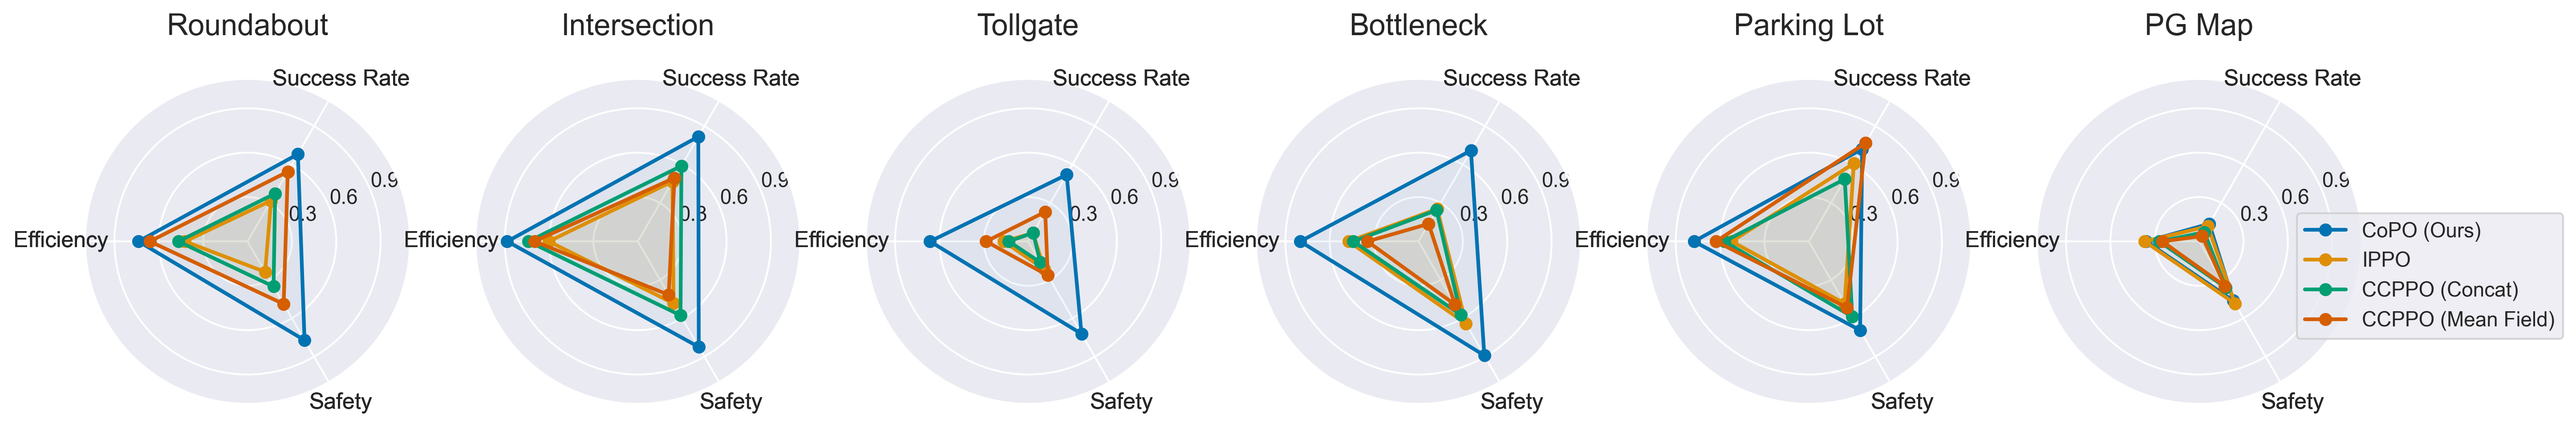

In [25]:
sns.set("notebook", "darkgrid")
c = sns.color_palette("colorblind")


# Rename and reorder environments and algorithms
env_mapping = {
    "Round": "Roundabout",
    "Inter": "Intersection",
    "Tollgate": "Tollgate",
    "Bottle": "Bottleneck",
    "Parking": "Parking Lot",
    "PGMap": "PG Map"
}

algo_mapping = {
    "1003_copo_formal": "CoPO (Ours)",
    "1003_ippo": "IPPO",
    "1011_ccppo_concat": "CCPPO (Concat)",
    "1012_ccppo_mf": "CCPPO (Mean Field)",
}

# matplotlib.rcParams['font.family'] = 'sans-serif'
fig = plt.figure(dpi=300, figsize=(22, 6))  

for env_count, env in enumerate(env_mapping.keys()):
    env_plot_data = final_plot_data_to_plot[final_plot_data_to_plot.env == env] 

    ax = fig.add_subplot(1, 6, env_count + 1, polar=True)
    
    for algo_count, algo in enumerate(algo_mapping.keys()):
        algo_plot_data = env_plot_data[env_plot_data.exp_name == algo]
    
        draw_labels = ["Competence", "Efficiency", "Safety"]
        plot_labels = ["Success Rate", "Efficiency", "Safety"]
        
        stats = [algo_plot_data[algo_plot_data.print_key == k].value.mean() for k in draw_labels]
        
        angles = np.linspace(0, 2*np.pi, len(draw_labels), endpoint=False)+ np.pi/2 - np.pi / 6
        stats = np.concatenate((stats, [stats[0]]))
        angles = np.concatenate((angles, [angles[0]]))

        ax.plot(angles, stats, 'o-', linewidth=2, label=algo_mapping[algo], c=c[algo_count])
        ax.fill(angles, stats, alpha=0.05, c=c[algo_count])
        ax.set_ylim(0, 1.1)
        
        # print("Env {}, Algo {}, {}, {}".format(env, algo, angles, plot_labels))
        ax.set_thetagrids(angles[:3] * 180/np.pi, plot_labels)
        
        ax.tick_params(pad=0)

        plt.gcf().canvas.draw()
        labels = []
        angles2 = [0, 0, 0]
        for label, angle in zip(ax.get_xticklabels(), angles2):
            x,y = label.get_position()
            lab = ax.text(x,y, label.get_text(), transform=label.get_transform(),
                          ha=label.get_ha(), va=label.get_va(),
                          fontname=label.get_fontname(),
                          fontstyle="normal",
                          fontweight="light"
                         )
            lab.set_rotation(angle)
        ax.set_xticklabels([])
        ax.set_yticks([0.3, 0.6, 0.9])
        ax.set_title(env_mapping[env], size=16, y=1.1)
        
ax.legend(loc=(0.8, 0.2))
fig.savefig("evaluate_result_1m.pdf".format(env), format='pdf', dpi=300, bbox_inches = "tight")
fig.savefig("evaluate_result_1m.png".format(env), format='png', dpi=300, bbox_inches = "tight")


In [26]:
for (print_key, print_key_df) in pd.DataFrame(final_plot_data_from_eval_data).groupby("print_key"):
    print(print_key)
    for (env, algo), gb in final_plot_data_to_plot.groupby(["env", "exp_name"]):
        print(env, '\t', algo, '\t', gb["value"].mean())
        
    print('\n\n')

Competence
Bottle 	 1003_copo_formal 	 0.8001340809306633
Bottle 	 1003_ippo 	 0.45580069114091365
Bottle 	 1011_ccppo_concat 	 0.41917566112985694
Bottle 	 1012_ccppo_mf 	 0.3249163518648597
Inter 	 1003_copo_formal 	 0.8419354916735534
Inter 	 1003_ippo 	 0.5182865926018463
Inter 	 1011_ccppo_concat 	 0.6354672865092387
Inter 	 1012_ccppo_mf 	 0.5374790974730427
PGMap 	 1003_copo_formal 	 0.3196880922621839
PGMap 	 1003_ippo 	 0.32408823853118024
PGMap 	 1011_ccppo_concat 	 0.23405867233795274
PGMap 	 1012_ccppo_mf 	 0.21341160410215884
Parking 	 1003_copo_formal 	 0.730792517765174
Parking 	 1003_ippo 	 0.5386638307420916
Parking 	 1011_ccppo_concat 	 0.5486502679674103
Parking 	 1012_ccppo_mf 	 0.6376099010586851
Round 	 1003_copo_formal 	 0.7301109710287982
Round 	 1003_ippo 	 0.32673863885922627
Round 	 1011_ccppo_concat 	 0.39803167256278976
Round 	 1012_ccppo_mf 	 0.5645875617997841
Tollgate 	 1003_copo_formal 	 0.6354686278019849
Tollgate 	 1003_ippo 	 0.14923897374098233
Toll